In [2]:
import dask
from dask.distributed import Client

try:
    client
except NameError:
    print("No dask client defined, starting client")
    client = Client(n_workers=16, threads_per_worker=2, memory_limit='30GB')  # start distributed scheduler locally.
else:
    print("Dask client already defined.")

# Display the client details to confirm it's running
client

No dask client defined, starting client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 32,Total memory: 447.03 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56536,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 447.03 GiB
Comm: tcp://127.0.0.1:56608,Total threads: 2
Dashboard: http://127.0.0.1:56610/status,Memory: 27.94 GiB
Nanny: tcp://127.0.0.1:56539,


In [21]:
import dask.dataframe as dd
import pandas as pd
import os

print(f'Dask version: {dask.__version__}')
print(f'Pandas version: {pd.__version__}')

# Directory containing CSV files
directory = r'data'

# Define standard columns and data types
standard_columns = [
    'MAC', 'Unix_time_Stamp', 'Date', 'Temp', 'Temp_sym', 
    'Humidity', 'Humidity_sym', 'Pressure', 'Pressure_sym', 
    'IDs_1', 'ID_1', 'Weight_1', 'Wt_sym_1', 
    'IDs_2', 'ID_2', 'Weight_2', 'Wt_sym_2', 
    'IDs_3', 'ID_3', 'Weight_3', 'Wt_sym_3', 
    'IDs_4', 'ID_4', 'Weight_4', 'Wt_sym_4', 
    'IDs_5', 'ID_5', 'Weight_5', 'Wt_sym_5'
]

# Define dtypes
dtypes = {
    'MAC': 'string',
    'Unix_time_Stamp': 'uint64',
    'Temp': 'float64',
    'Temp_sym': 'string',
    'Humidity': 'float64',
    'Humidity_sym': 'string',
    'Pressure': 'int64',
    'Pressure_sym': 'string',
    'IDs_1': 'string',
    'ID_1': 'int64',
    'Weight_1': 'int64',
    'Wt_sym_1': 'string', 
    'IDs_2': 'string',
    'ID_2': 'int64',
    'Weight_2': 'int64',
    'Wt_sym_2': 'string', 
    'IDs_3': 'string',
    'ID_3': 'int64',
    'Weight_3': 'int64',
    'Wt_sym_3': 'string', 
    'IDs_4': 'string',
    'ID_4': 'int64',
    'Weight_4': 'int64',
    'Wt_sym_4': 'string', 
    'IDs_5': 'string',
    'ID_5': 'int64',
    'Weight_5': 'int64',
    'Wt_sym_5': 'string'
}

# List all CSV files in the directory
csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]

# Read all CSV files with Dask
ddf = dd.read_csv(csv_files, header=None, assume_missing=True)

# Rename columns and reorder
ddf = ddf.rename(columns=dict(enumerate(standard_columns)))
ddf = ddf[[col for col in standard_columns if col in ddf.columns]]

# Convert data types
for col, dtype in dtypes.items():
    if dtype == 'int64':
        ddf[col] = dd.to_numeric(ddf[col], errors='coerce').astype('Int64')
    elif dtype == 'float64':
        ddf[col] = dd.to_numeric(ddf[col], errors='coerce').astype('float64')
    else:
        ddf[col] = ddf[col].astype(dtype)

# Convert Pressure to float64 and divide by 1000
ddf['Pressure'] = (ddf['Pressure'] / 1000).astype('float64')
print("4")
# Compute the DataFrame (trigger computation)
combined_df = ddf.compute()
print("5")
# Display the first few rows
display(combined_df.head())


# Identify log events or incorrect entries
log_event_stopped_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event stopped', na=False)]

log_event_start_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event started', na=False)]

# Assume that any row without a standard number of columns or containing 'Log event started' is incorrect
incorrect_entries_df = combined_df[combined_df['Pressure_sym'].str.contains('Log event started', na=False) | (combined_df['Weight_1'].isna())]

# Extract rows that fit the correct structure (excluding log events)
correct_entries_df = combined_df[~combined_df.index.isin(incorrect_entries_df.index)]


import matplotlib.pyplot as plt

# Display the first few rows of each DataFrame
print("Log Event Starts:")
display(log_event_start_df.head())

print("Log Event Stopped:")
display(log_event_stopped_df.head())


print("Incorrect Entries:")
display(incorrect_entries_df.head())

print("Correct Entries:")
display(correct_entries_df.head())

# Optional: Save these DataFrames to separate CSV files for further analysis
log_event_start_df.to_csv('log_event_starts.csv', index=False)
log_event_stopped_df.to_csv('log_event_stopped.csv', index=False)
incorrect_entries_df.to_csv('incorrect_entries.csv', index=False)
correct_entries_df.to_csv('correct_entries.csv', index=False)


Dask version: 2024.5.0
Pandas version: 2.2.2
4
5


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
0,7C:DF:A1:E0:91:AC,1674573949,2023-01-24T15:25:49Z,22.2,C,30.0,%,96.121,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,7C:DF:A1:E0:91:AC,1674573949,2023-01-24T15:25:49Z,22.2,C,30.0,%,96.121,hPa,id,1,824,g,id,2,171,g,id,3,580,g,id,4,517,g,id,5,399,g
2,7C:DF:A1:E0:91:AC,1674574200,2023-01-24T15:30:00Z,22.1,C,30.7,%,96.144,hPa,id,1,820,g,id,2,170,g,id,3,579,g,id,4,516,g,id,5,399,g
3,7C:DF:A1:E0:91:AC,1674576000,2023-01-24T16:00:00Z,22.1,C,29.1,%,96.272,hPa,id,1,817,g,id,2,169,g,id,3,576,g,id,4,512,g,id,5,398,g
4,7C:DF:A1:E0:91:AC,1674577800,2023-01-24T16:30:00Z,21.1,C,29.6,%,96.379,hPa,id,1,814,g,id,2,169,g,id,3,573,g,id,4,509,g,id,5,397,g


Log Event Starts:


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
0,7C:DF:A1:E0:91:AC,1674573949,2023-01-24T15:25:49Z,22.2,C,30.0,%,96.121,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
20,7C:DF:A1:E0:91:AC,1675675800,2023-02-06T09:15:00Z,18.8,C,25.9,%,98.905,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
40,7C:DF:A1:E0:91:AC,1679082025,2023-03-17T19:40:25Z,20.9,C,27.0,%,97.688,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
20,7C:DF:A1:E0:91:AC,1679995436,2023-03-28T09:23:56Z,20.4,C,28.1,%,98.778,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
41,7C:DF:A1:E0:91:AC,1682280615,2023-04-23T20:10:15Z,20.7,C,31.6,%,99.950,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Log Event Stopped:


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
19,7C:DF:A1:E0:91:AC,1675675800,2023-02-06T09:10:00Z,18.8,C,25.9,%,98.905,hPaLog event stopped.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
24,7C:DF:A1:E0:91:AC,1676462400,2023-02-15T12:00:00Z,19.0,C,21.9,%,99.049,hPaLog event stopped.,id,1,0,g,id,2,3,g,id,3,2,g,id,4,-2,g,id,5,1,g
19,6C:DF:A1:E0:91:AC,1679995435,2023-03-28T09:13:56Z,19.4,C,27.1,%,98.777,hPaLog event stopped.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
43,6C:DF:A1:E0:91:AC,1680989399,2023-04-08T21:30:00Z,18.4,C,22.1,%,98.951,hPaLog event stopped.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
23,7C:DF:A1:E0:91:AC,1683630882,2023-05-09T11:14:42Z,21.3,C,27.4,%,96.955,hPaLog event stopped.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Incorrect Entries:


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
0,7C:DF:A1:E0:91:AC,1674573949,2023-01-24T15:25:49Z,22.2,C,30.0,%,96.121,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
19,7C:DF:A1:E0:91:AC,1675675800,2023-02-06T09:10:00Z,18.8,C,25.9,%,98.905,hPaLog event stopped.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
20,7C:DF:A1:E0:91:AC,1675675800,2023-02-06T09:15:00Z,18.8,C,25.9,%,98.905,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
40,7C:DF:A1:E0:91:AC,1679082025,2023-03-17T19:40:25Z,20.9,C,27.0,%,97.688,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
19,6C:DF:A1:E0:91:AC,1679995435,2023-03-28T09:13:56Z,19.4,C,27.1,%,98.777,hPaLog event stopped.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Correct Entries:


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
2,7C:DF:A1:E0:91:AC,1674574200,2023-01-24T15:30:00Z,22.1,C,30.7,%,96.144,hPa,id,1,820,g,id,2,170,g,id,3,579,g,id,4,516,g,id,5,399,g
3,7C:DF:A1:E0:91:AC,1674576000,2023-01-24T16:00:00Z,22.1,C,29.1,%,96.272,hPa,id,1,817,g,id,2,169,g,id,3,576,g,id,4,512,g,id,5,398,g
4,7C:DF:A1:E0:91:AC,1674577800,2023-01-24T16:30:00Z,21.1,C,29.6,%,96.379,hPa,id,1,814,g,id,2,169,g,id,3,573,g,id,4,509,g,id,5,397,g
5,7C:DF:A1:E0:91:AC,1674579600,2023-01-24T17:00:00Z,20.6,C,29.8,%,96.458,hPa,id,1,812,g,id,2,169,g,id,3,571,g,id,4,506,g,id,5,396,g
6,7C:DF:A1:E0:91:AC,1674581400,2023-01-24T17:30:00Z,20.2,C,30.5,%,96.552,hPa,id,1,809,g,id,2,168,g,id,3,568,g,id,4,504,g,id,5,395,g


In [22]:
# Print the first few rows of the combined DataFrame
print(combined_df.shape)
display(combined_df.head())
display(combined_df.tail())

(26442, 29)


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
0,7C:DF:A1:E0:91:AC,1674573949,2023-01-24T15:25:49Z,22.2,C,30.0,%,96.121,hPaLog event started.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,7C:DF:A1:E0:91:AC,1674573949,2023-01-24T15:25:49Z,22.2,C,30.0,%,96.121,hPa,id,1,824,g,id,2,171,g,id,3,580,g,id,4,517,g,id,5,399,g
2,7C:DF:A1:E0:91:AC,1674574200,2023-01-24T15:30:00Z,22.1,C,30.7,%,96.144,hPa,id,1,820,g,id,2,170,g,id,3,579,g,id,4,516,g,id,5,399,g
3,7C:DF:A1:E0:91:AC,1674576000,2023-01-24T16:00:00Z,22.1,C,29.1,%,96.272,hPa,id,1,817,g,id,2,169,g,id,3,576,g,id,4,512,g,id,5,398,g
4,7C:DF:A1:E0:91:AC,1674577800,2023-01-24T16:30:00Z,21.1,C,29.6,%,96.379,hPa,id,1,814,g,id,2,169,g,id,3,573,g,id,4,509,g,id,5,397,g


,MAC,Unix_time_Stamp,Date,Temp,Temp_sym,Humidity,Humidity_sym,Pressure,Pressure_sym,IDs_1,ID_1,Weight_1,Wt_sym_1,IDs_2,ID_2,Weight_2,Wt_sym_2,IDs_3,ID_3,Weight_3,Wt_sym_3,IDs_4,ID_4,Weight_4,Wt_sym_4,IDs_5,ID_5,Weight_5,Wt_sym_5
43,7C:DF:A1:E0:91:AC,1722202200,2024-07-28T21:30:00Z,26.1,C,43.5,%,99.087,hPa,id,1,466,g,id,2,0,g,id,3,0,g,id,4,103,g,id,5,564,g
44,7C:DF:A1:E0:91:AC,1722204000,2024-07-28T22:00:00Z,26.0,C,42.9,%,99.118,hPa,id,1,466,g,id,2,0,g,id,3,0,g,id,4,103,g,id,5,564,g
45,7C:DF:A1:E0:91:AC,1722205800,2024-07-28T22:30:00Z,26.0,C,42.2,%,99.170,hPa,id,1,466,g,id,2,0,g,id,3,0,g,id,4,103,g,id,5,564,g
46,7C:DF:A1:E0:91:AC,1722207600,2024-07-28T23:00:00Z,25.9,C,41.9,%,99.183,hPa,id,1,466,g,id,2,1,g,id,3,0,g,id,4,102,g,id,5,564,g
47,7C:DF:A1:E0:91:AC,1722209400,2024-07-28T23:30:00Z,25.9,C,42.2,%,99.174,hPa,id,1,466,g,id,2,1,g,id,3,0,g,id,4,102,g,id,5,564,g


C:\Users\Neil\AppData\Local\Temp\ipykernel_26408\663467581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_event_start_df['Date'] = pd.to_datetime(log_event_start_df['Date'])
C:\Users\Neil\AppData\Local\Temp\ipykernel_26408\663467581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_event_stopped_df['Date'] = pd.to_datetime(log_event_stopped_df['Date'])


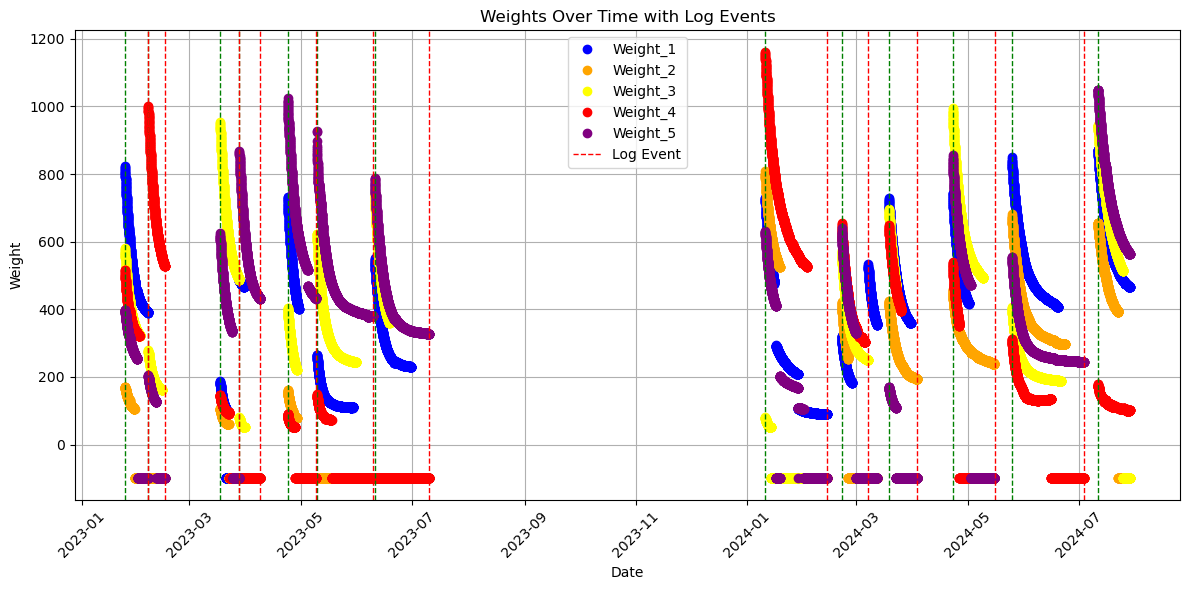

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
# Ensure 'Date' is a datetime column for proper plotting
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
log_event_start_df['Date'] = pd.to_datetime(log_event_start_df['Date'])
log_event_stopped_df['Date'] = pd.to_datetime(log_event_stopped_df['Date'])


# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], filtered_df['Weight_1'], marker='o', linestyle='', color='b', label='Weight_1')
plt.plot(filtered_df['Date'], filtered_df['Weight_2'], marker='o', linestyle='', color='orange', label='Weight_2')
plt.plot(filtered_df['Date'], filtered_df['Weight_3'], marker='o', linestyle='', color='yellow', label='Weight_3')
plt.plot(filtered_df['Date'], filtered_df['Weight_4'], marker='o', linestyle='', color='red', label='Weight_4')
plt.plot(filtered_df['Date'], filtered_df['Weight_5'], marker='o', linestyle='', color='purple', label='Weight_5')

# Add vertical lines for each entry in log_event_start_df
for log_date in log_event_start_df['Date']:
    plt.axvline(x=log_date, color='green', linestyle='--', linewidth=1, label='Log Event')

# Add vertical lines for each entry in log_event_start_df
for log_date in log_event_stopped_df['Date']:
    plt.axvline(x=log_date, color='red', linestyle='--', linewidth=1, label='Log Event')

plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Weights Over Time with Log Events')
plt.grid(True)
plt.xticks(rotation=45)

# Handle legend: Remove duplicate labels for vertical lines
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()


C:\Users\Neil\AppData\Local\Temp\ipykernel_26408\3645983846.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_event_start_df['Date'] = pd.to_datetime(log_event_start_df['Date']).dt.tz_localize(None)
C:\Users\Neil\AppData\Local\Temp\ipykernel_26408\3645983846.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_event_stopped_df['Date'] = pd.to_datetime(log_event_stopped_df['Date']).dt.tz_localize(None)


Start: 2023-01-24 15:30:00
End: 2023-02-06 09:00:00


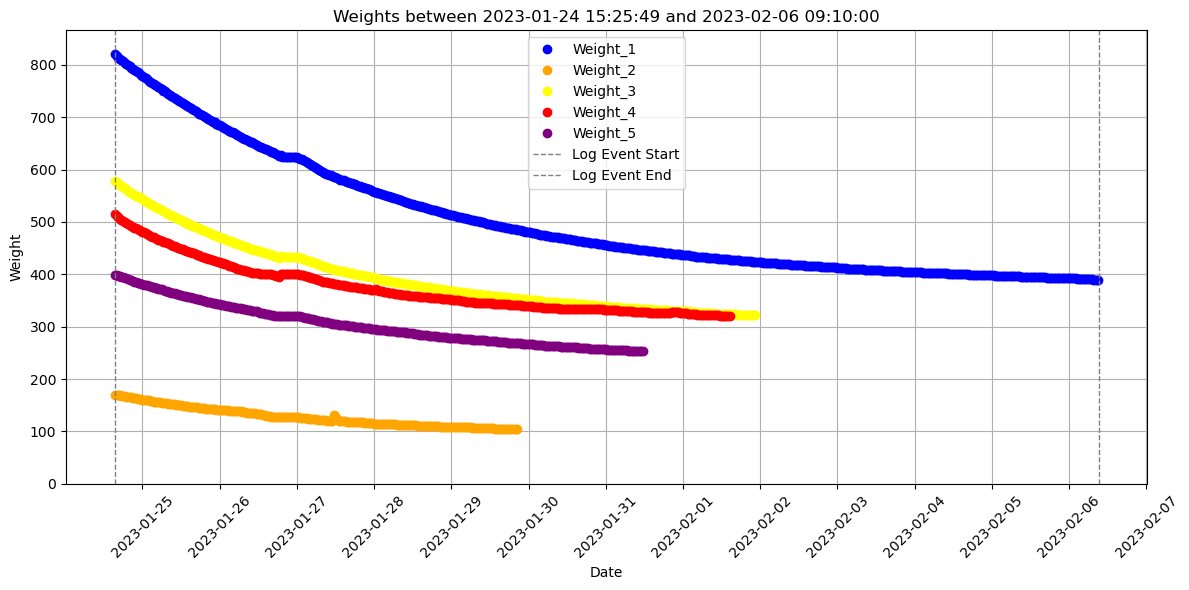

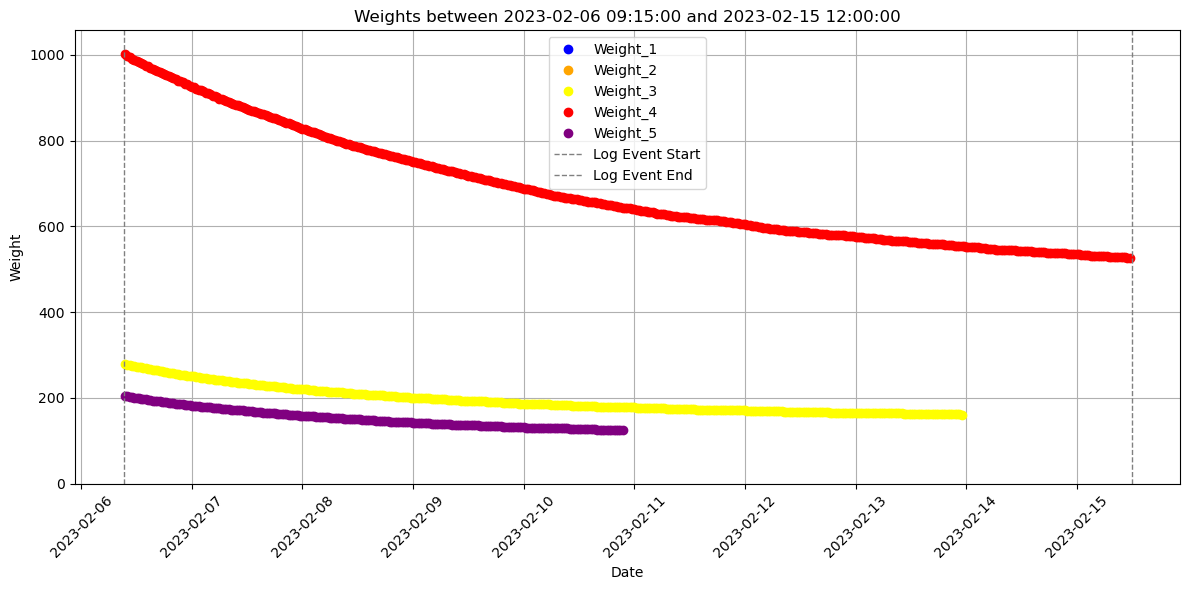

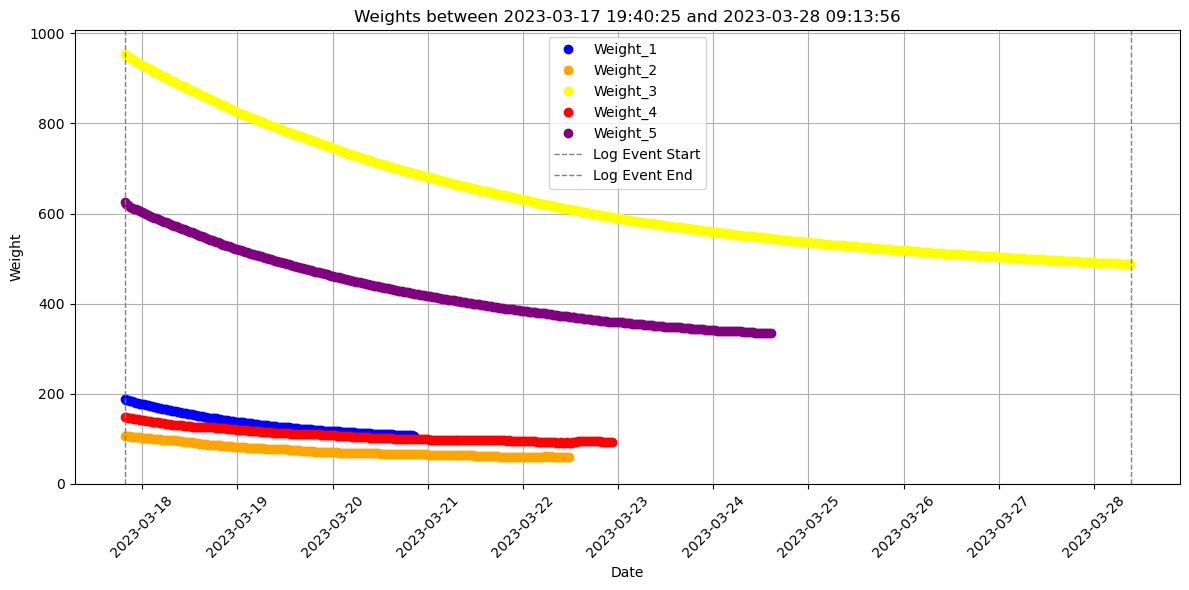

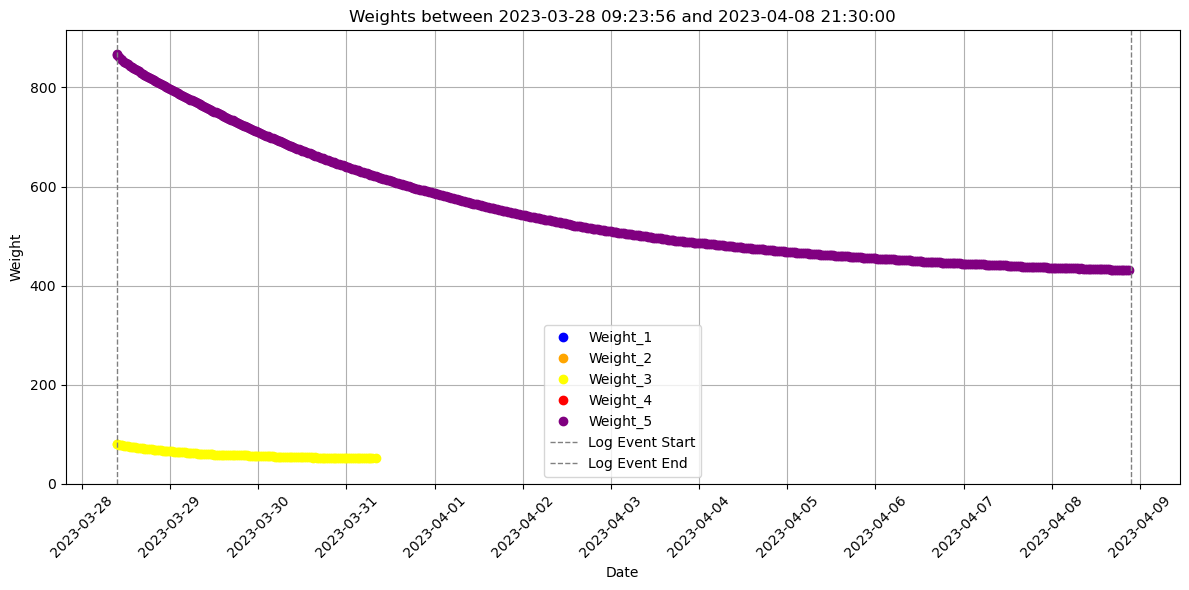

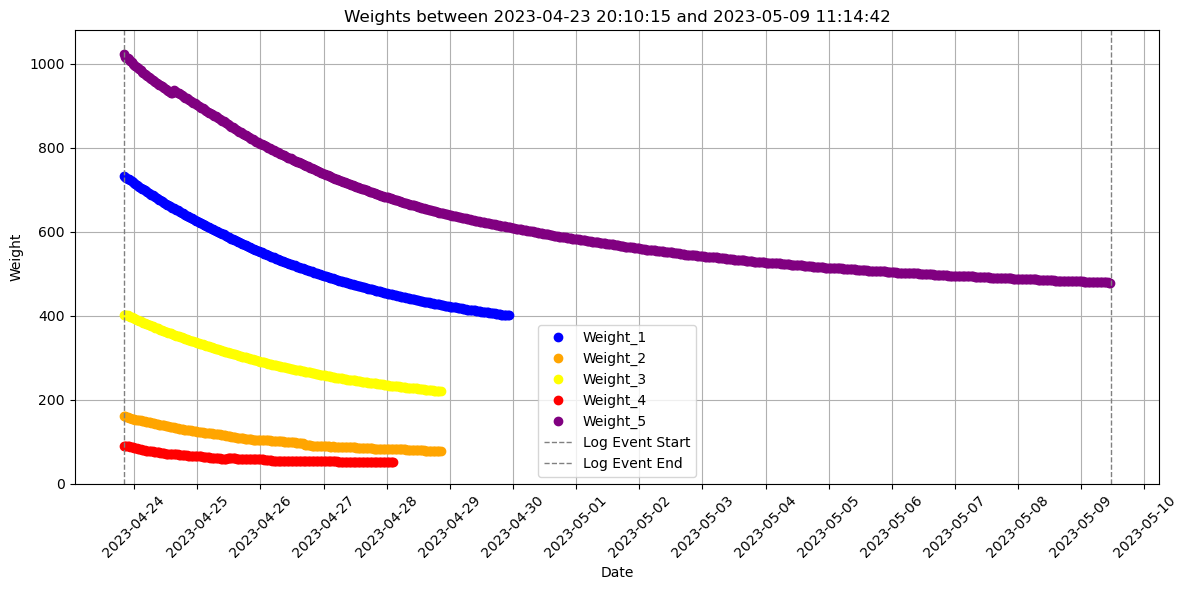

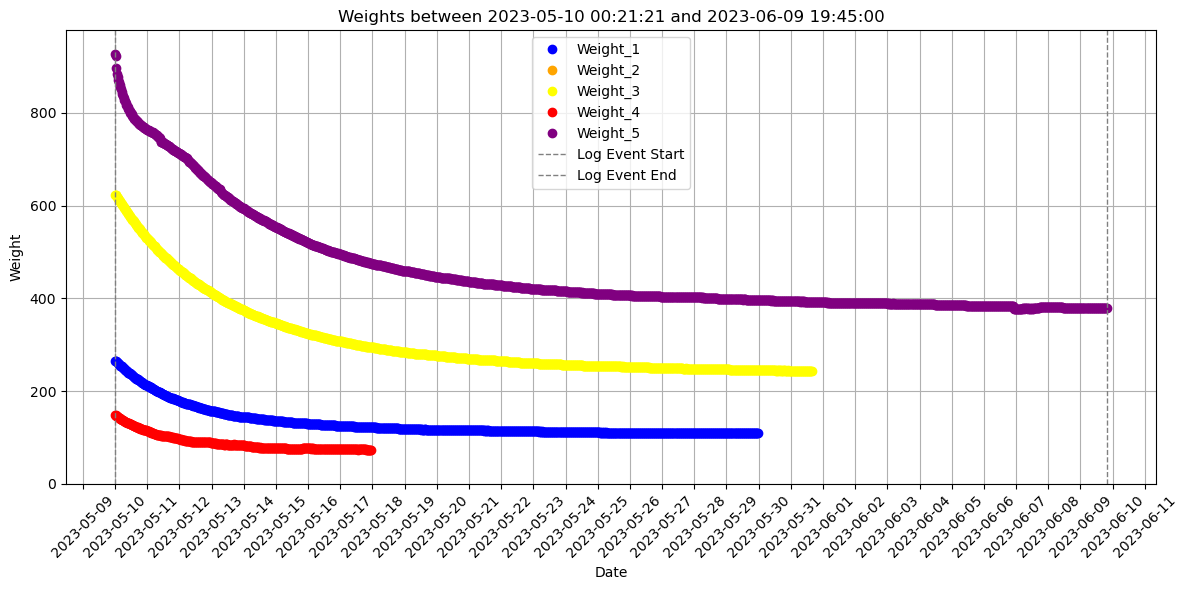

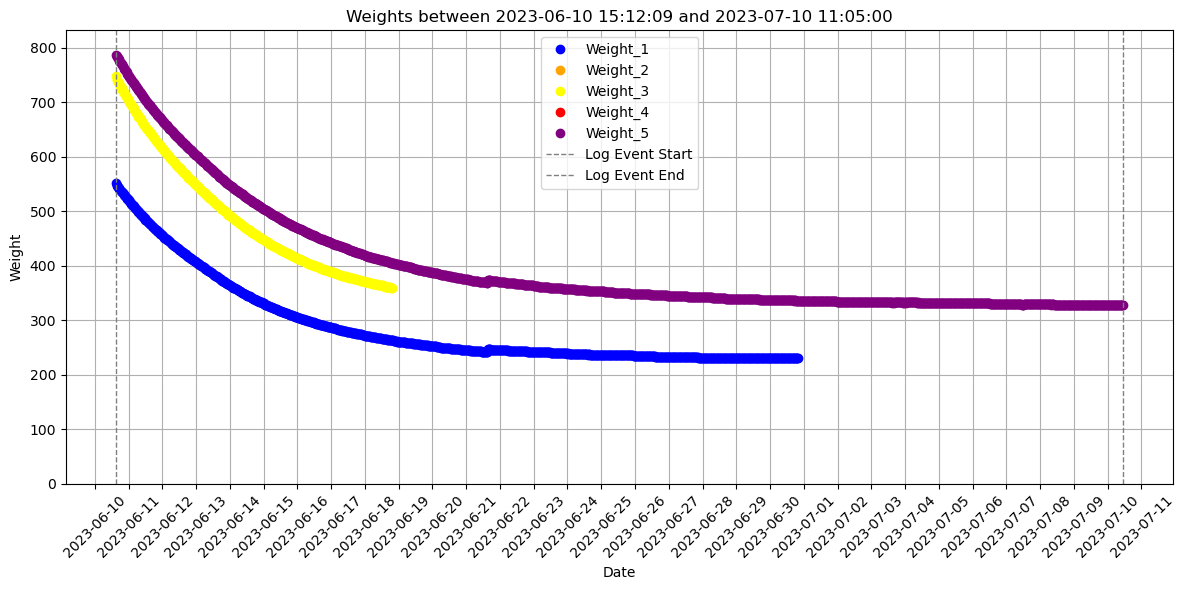

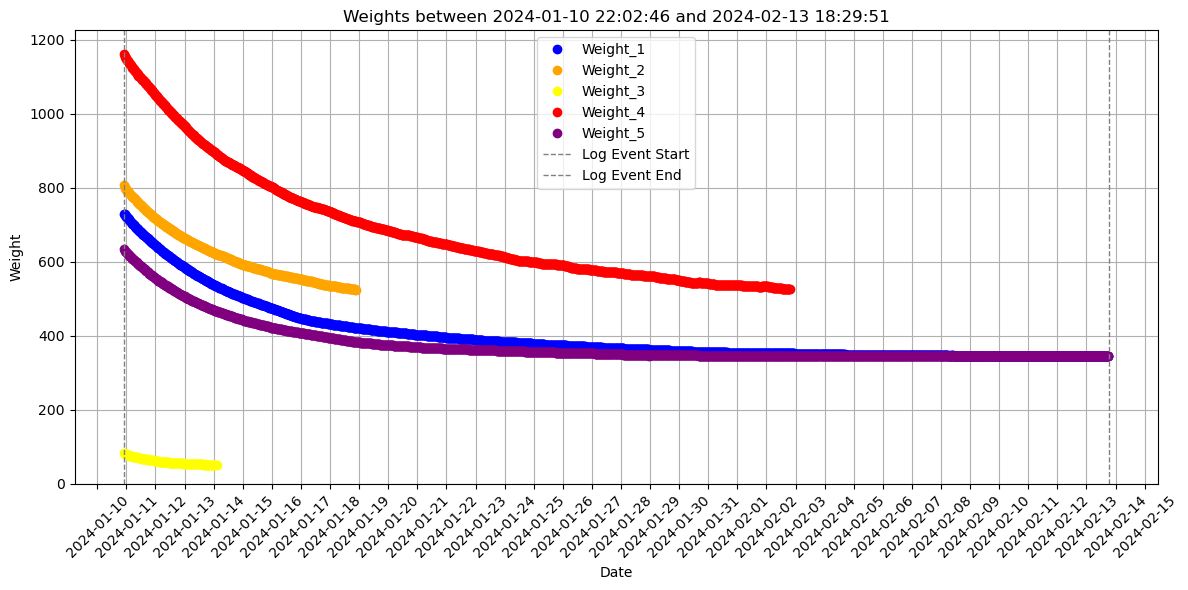

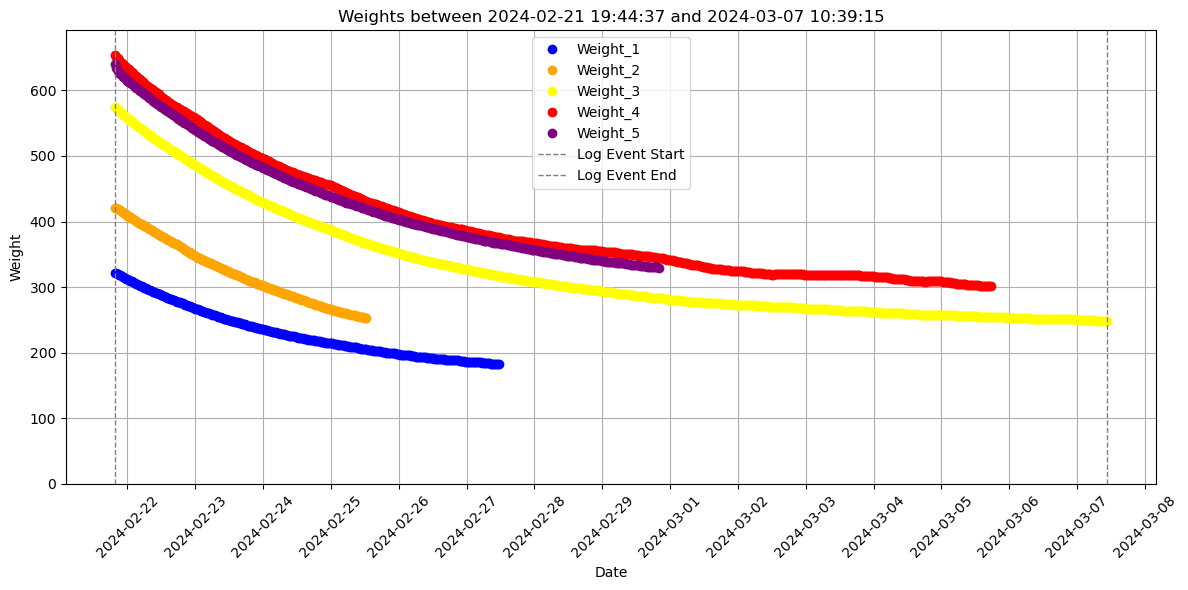

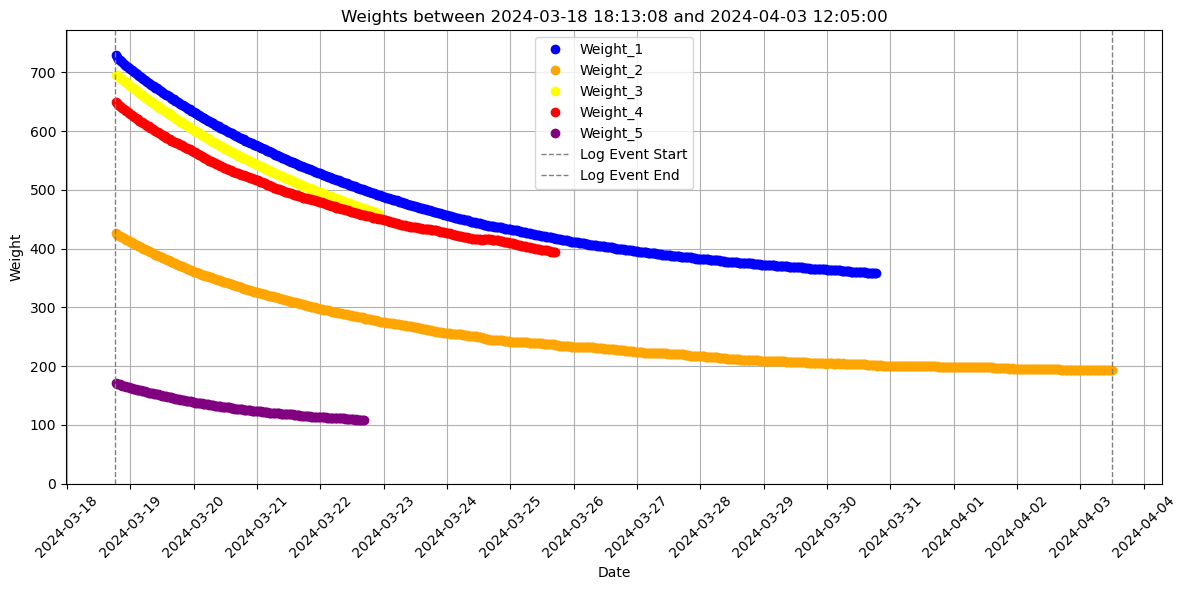

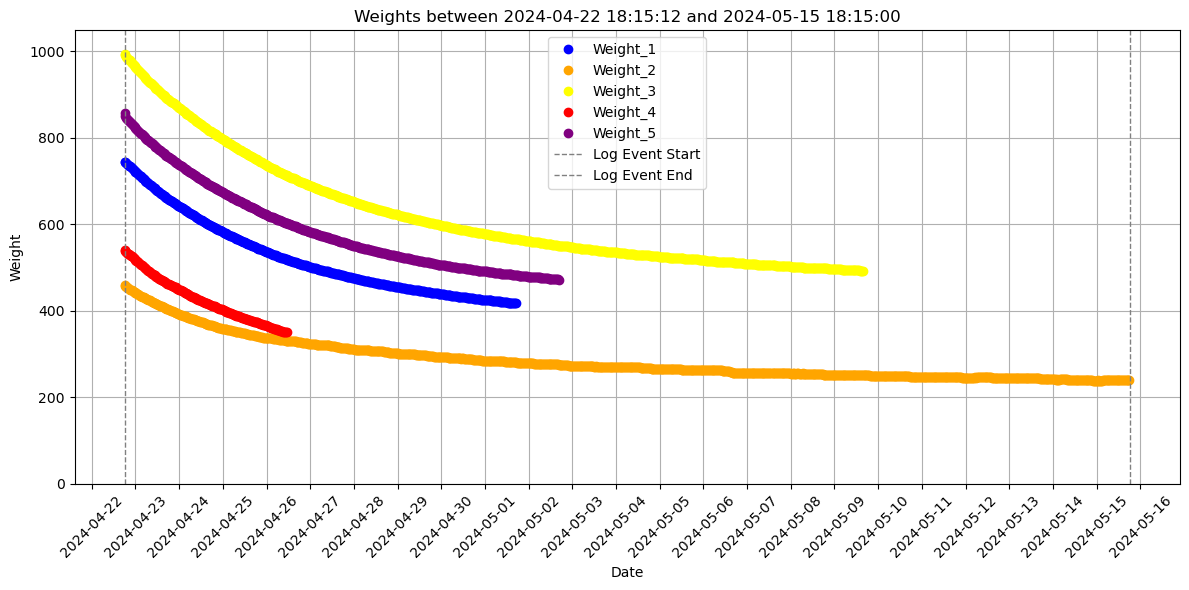

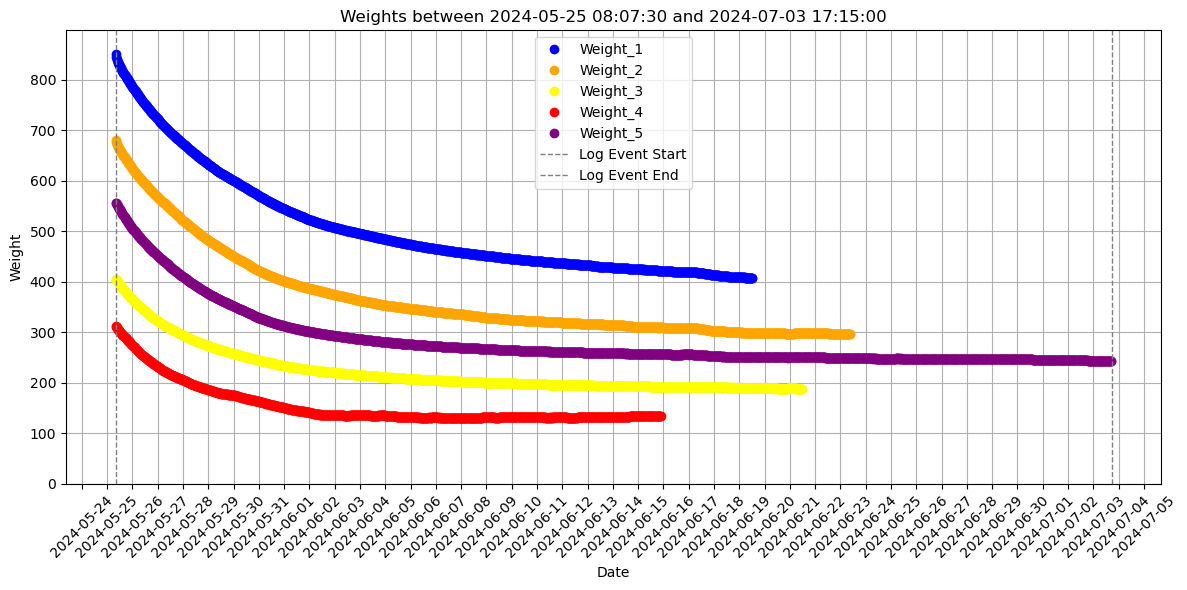

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust the width of the display
pd.set_option('display.max_colwidth', None)  # Show the full content of each cell


# Ensure 'Date' is a datetime column for proper plotting
combined_df['Date'] = pd.to_datetime(combined_df['Date']).dt.tz_localize(None)
log_event_start_df['Date'] = pd.to_datetime(log_event_start_df['Date']).dt.tz_localize(None)
log_event_stopped_df['Date'] = pd.to_datetime(log_event_stopped_df['Date']).dt.tz_localize(None)

# Filter the combined_df to include only rows where weights are greater than 50
filtered_df = combined_df[
    (combined_df['Weight_1'] > 50) | 
    (combined_df['Weight_2'] > 50) | 
    (combined_df['Weight_3'] > 50) | 
    (combined_df['Weight_4'] > 50) | 
    (combined_df['Weight_5'] > 50)
].copy()  # Create a copy of the filtered DataFrame

# Replace weights below 50 with -100 for visualization purposes
weights = ['Weight_1', 'Weight_2', 'Weight_3', 'Weight_4', 'Weight_5']
for weight in weights:
    filtered_df.loc[filtered_df[weight] <= 50, weight] = -100

# Sort log_event_start_df by 'Date'
log_event_start_df = log_event_start_df.sort_values(by='Date')
log_event_stopped_df = log_event_stopped_df.sort_values(by='Date')

#------------Filter date ranges
# Define the date range
start_date = pd.Timestamp('2021-04-20')
end_date = pd.Timestamp('2025-05-14')

# Filter log_event_start_df
log_event_start_fil_df = log_event_start_df[(log_event_start_df['Date'] >= start_date) & (log_event_start_df['Date'] <= end_date)]

# Filter log_event_stopped_df
log_event_stopped_fil_df = log_event_stopped_df[(log_event_stopped_df['Date'] >= start_date) & (log_event_stopped_df['Date'] <= end_date)]
#------------Filter date ranges

# Plot data between each pair of log events
for i in range(len(log_event_start_fil_df) - 1):
    start_date = log_event_start_fil_df.iloc[i]['Date']
    end_date = log_event_stopped_fil_df.iloc[i]['Date']

    # Filter data between the current and next log event
    plot_df = filtered_df[(filtered_df['Date'] >= start_date) & (filtered_df['Date'] <= end_date)]

    #----------------------------Works for first set
    if (i==0):
        #display(plot_df)
        data = plot_df.copy()
        # Convert 'Date' column to datetime
        data['Date'] = pd.to_datetime(data['Date'])

        # Set 'Date' column as index
        data.set_index('Date', inplace=True)

        #display(data.head())
        data = data.iloc[1:]
        #display(data.head())

        # Generate a complete range of timestamps
        full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='30min')
        print("Start:",data.index.min())
        print("End:",data.index.max())

        # Reindex DataFrame to include all timestamps
        
        data = data.reindex(full_range)
        #display(data.head(10))
        # Ensure all columns are numeric for interpolation
        data = data.apply(pd.to_numeric, errors='coerce')

        # Interpolate missing values
        data.interpolate(method='linear', inplace=True)

        # Reset index to make 'Date' a column again if needed
        data.reset_index(inplace=True)
        data.rename(columns={'index': 'Date'}, inplace=True)

        plot_df=data.copy()
    #----------------------------Works for first set

    #-----------------To identify sudden jumps
    # Calculate the difference in Weight

    # for Weight in weights:
    if (i==3):
        plot_df.loc[:, 'Weight_1'] = np.nan
    if (i==4):
        plot_df = plot_df.reset_index(drop=True)

        # Find the index of the specific row
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2023-05-04 22:00:00')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 47

    if (i==7):
        plot_df = plot_df.reset_index(drop=True)
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-16 21:30:01')].index[0]
        plot_df.loc[row_index:, 'Weight_1'] += 155

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:00:01')].index[0]
        plot_df.loc[row_index:, 'Weight_1'] += 100

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:00:01')].index[0]
        plot_df.loc[row_index:row_index, 'Weight_1'] += 200
        

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-18 22:00:01')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 180
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:30:01')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 60
        
        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-02-01 00:00:02')].index[0]
        plot_df.loc[row_index:, 'Weight_5'] += 205

        row_index = plot_df[(plot_df['MAC'] == '7C:DF:A1:E0:91:AC') & (plot_df['Date'] == '2024-01-28 23:30:01')].index[0]
        plot_df.loc[row_index:row_index, 'Weight_5'] += 205

        #------Specific data range to modify
        start_date_1 = '2024-01-15 23:00:01'
        end_date_1 = '2024-01-16 21:30:01'

        row_index_s = plot_df[(plot_df['Date'] == start_date_1)].index[0]
        row_index_e = plot_df[(plot_df['Date'] == end_date_1)].index[0]

        # Filter DataFrame for the date range
        plot_df.loc[row_index_s:row_index_e, 'Weight_1'] = np.nan
        plot_df['Weight_1'] = plot_df['Weight_1'].interpolate()

        #------Specific data range to modify
        start_date_1 = '2024-01-16 21:30:01'
        end_date_1 = '2024-01-18 22:00:01'

        row_index_s = plot_df[(plot_df['Date'] == start_date_1)].index[0]
        row_index_e = plot_df[(plot_df['Date'] == end_date_1)].index[0]

        # Filter DataFrame for the date range
        plot_df.loc[row_index_s:row_index_e, 'Weight_5'] = np.nan
        # df['Weight_1'] = df['Weight_1'].replace(-100, pd.NA)  # Replace -100 with NaN for interpolation
        plot_df['Weight_5'] = plot_df['Weight_5'].interpolate()

        # sliced_df = plot_df.copy()
        # sliced_df['Weight_Diff'] = sliced_df["Weight_5"].diff()

        # # Define the threshold for sudden jump
        # threshold = 50  # Adjust this value based on your requirements

        # # Identify sudden jumps
        # sudden_jumps = sliced_df[abs(sliced_df['Weight_Diff']) > threshold]
        # up_jumps = sliced_df[(sliced_df['Weight_Diff']) > threshold]
        # down_jumps = sliced_df[(sliced_df['Weight_Diff']) < -threshold]

        # print("Rows with sudden jumps:")
        # display(sudden_jumps)

        # print("Rows with down jumps:")
        # display(down_jumps)

        # print("Rows with up jumps:")
        # display(up_jumps)

    #-----------------To identify sudden jumps
    if (i!=17):

        # Define a function to export weights
        def export_weights(df):
            for j in range(1, 6):  # Loop for weights from 1 to 5
                weight_col = f'Weight_{j}'
                filtered_df = df[df[weight_col] > 50].copy()  # Filter for weights greater than 50
                
                if not filtered_df.empty:  # Proceed only if there are values greater than 50
                    filtered_df['Jerky_ID'] = f"{i},{j}"  # Set the Jerky_ID column with a constant value for all rows
                    export_columns = ['Jerky_ID', 'Unix_time_Stamp', 'Date', 'Temp', 'Humidity', weight_col]
                    filtered_df = filtered_df[export_columns]  # Select required columns
                    
                    # Use raw string or double backslashes for file path
                    directory = r'pdata'  # Or use 'pdata\\'
                    filename = f'{directory}\\Jerky_{i}_{weight_col}.csv'
                    filtered_df.to_csv(filename, index=False)  # Export to CSV

        # Call the function to export weights
        export_weights(plot_df)

        plt.figure(figsize=(12, 6))
        plt.plot(plot_df['Date'], plot_df['Weight_1'], marker='o', linestyle='', color='b', label='Weight_1')
        plt.plot(plot_df['Date'], plot_df['Weight_2'], marker='o', linestyle='', color='orange', label='Weight_2')
        plt.plot(plot_df['Date'], plot_df['Weight_3'], marker='o', linestyle='', color='yellow', label='Weight_3')
        plt.plot(plot_df['Date'], plot_df['Weight_4'], marker='o', linestyle='', color='red', label='Weight_4')
        plt.plot(plot_df['Date'], plot_df['Weight_5'], marker='o', linestyle='', color='purple', label='Weight_5')
        
        plt.axvline(x=start_date, color='gray', linestyle='--', linewidth=1, label='Log Event Start')
        plt.axvline(x=end_date, color='gray', linestyle='--', linewidth=1, label='Log Event End')
        
        # Formatting the x-axis to show 1-day intervals
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        
        plt.xlabel('Date')
        plt.ylabel('Weight')
        plt.title(f'Weights between {start_date} and {end_date}')
        plt.legend()
        plt.grid(True)
        plt.ylim(bottom=0)  # Ensure y-axis starts at 0
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [2]:
try:
    client
except NameError:
    print("No dask client defined, nothing to shut down.")
else:
    print("Shutting down the Dask client.")
    client.close()
    del client

Shutting down the Dask client.
